In [72]:
#Import relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date,timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans



# Task 1 
### Investigate and Analyse Price data


##### Background
You are a quantitative researcher working with a commodity trading desk. Alex, a VP on the desk, wants to start trading natural gas storage contracts. However, the available market data must be of higher quality to enable the instrument to be priced accurately. They have sent you an email asking you to help extrapolate the data available from external feeds to provide more granularity, considering seasonal trends in the price as it relates to months in the year. To price the contract, we will need historical data and an estimate of the future gas price at any date.

Commodity storage contracts represent deals between warehouse (storage) owners and participants in the supply chain (refineries, transporters, distributors, etc.). The deal is typically an agreement to store an agreed quantity of any physical commodity (oil, natural gas, agriculture) in a warehouse for a specified amount of time. The key terms of such contracts (e.g., periodic fees for storage, limits on withdrawals/injections of a commodity) are agreed upon inception of the contract between the warehouse owner and the client. The injection date is when the commodity is purchased and stored, and the withdrawal date is when the commodity is withdrawn from storage and sold. 

A client could be anyone who would fall within the commodities supply chain, such as producers, refiners, transporters, and distributors. This group would also include firms (commodities trading, hedge funds, etc.) whose primary aim is to take advantage of seasonal or intra-day price differentials in physical commodities. For example, if a firm is looking to buy physical natural gas during summer and sell it in winter, it would take advantage of the seasonal price differential mentioned above. The firm would need to leverage the services of an underground storage facility to store the purchased inventory to realize any profits from this strategy.

### Task
After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file.

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

Download the monthly natural gas price data.
Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
Your code should take a date as input and return a price estimate.
Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for. 

In [8]:
# Reading data
df = pd.read_csv('../Data/Nat_Gas.csv')


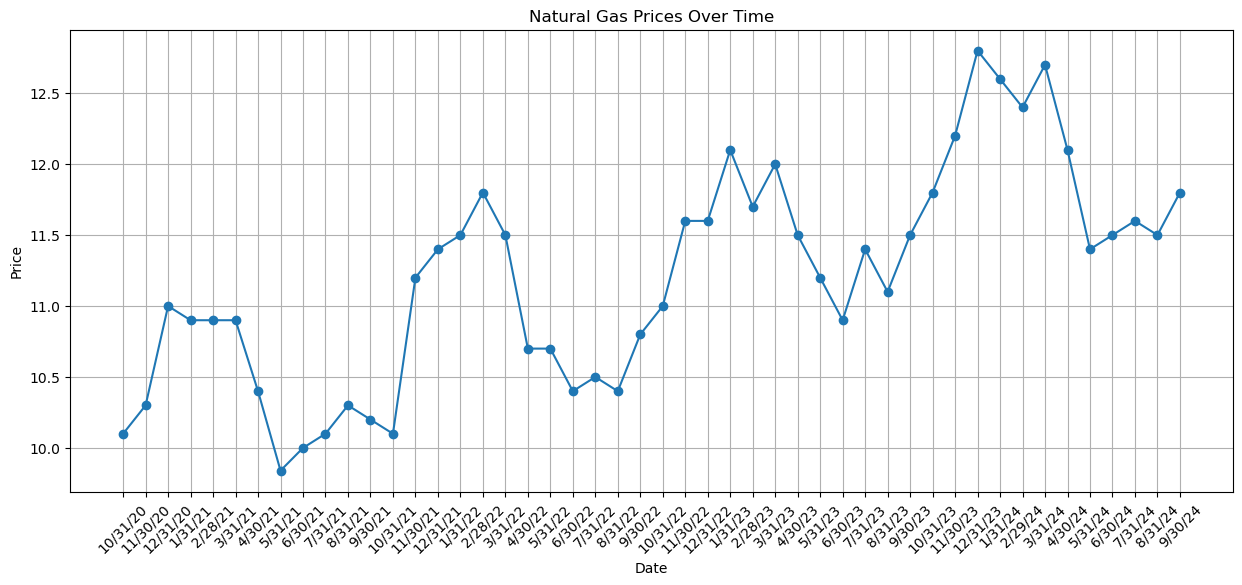

In [9]:
# Plotting the data
plt.figure(figsize=(15, 6))
plt.plot(df['Dates'], df['Prices'], marker='o')
plt.title('Natural Gas Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

In [32]:
df['Dates'] = pd.to_datetime(df['Dates'])
prices = df['Prices'].values

# Calculate days from the start
start_date = date(2020,10,31)
end_date = date(2024,9,30)
start_date_days = start_date.toordinal()
df['Date_ordinal'] = df['Dates'].apply(lambda x: x.toordinal() - start_date_days)
df.head()

,Dates,Prices,Date_ordinal
0,2020-10-31,10.1,0
1,2020-11-30,10.3,30
2,2020-12-31,11.0,61
3,2021-01-31,10.9,92
4,2021-02-28,10.9,120


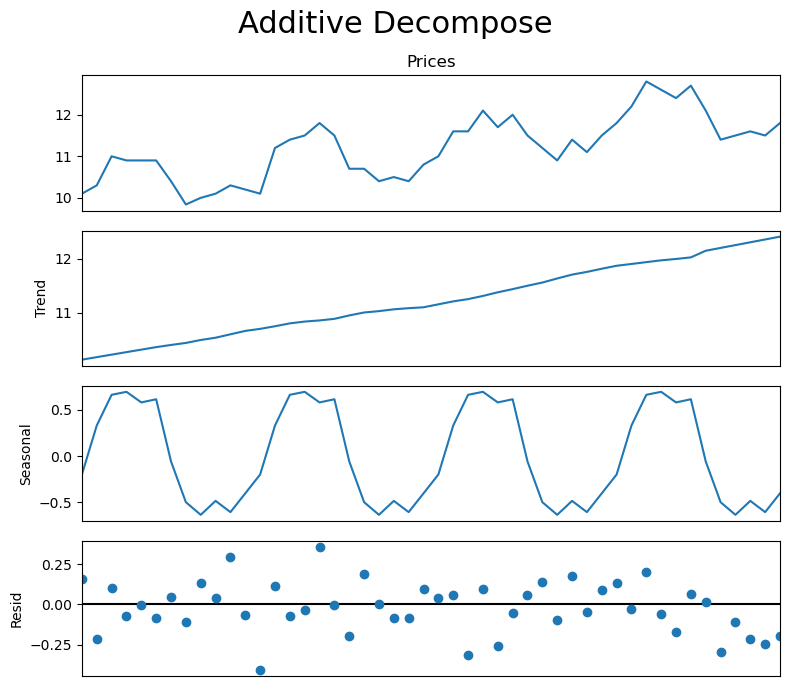

In [24]:

result_add = seasonal_decompose(df['Prices'], model='additive', extrapolate_trend='freq', period=12)

# Plotting Additive Decomposition
fig = result_add.plot()
fig.set_size_inches(8,7)
axes = fig.axes

for ax in axes[:]:
    ax.set_xticks([])


plt.suptitle('Additive Decompose', fontsize=22)
plt.tight_layout()
plt.show()


There seems to be a recurring seasonal trend where the price of natural gas increases around the end of the year and decreases in the middle of the year. This suggests that there might be hixgher demand during the colder months, leading to higher prices, and reduced demand during warmer months, leading to lower prices.
Apart from seasonality there is an overall upward trend in price
Use an additive seasonality as the seasonal amplitudes remained the same

Text(0.5, 1.0, 'Linear regression of Nat Gas Prices')

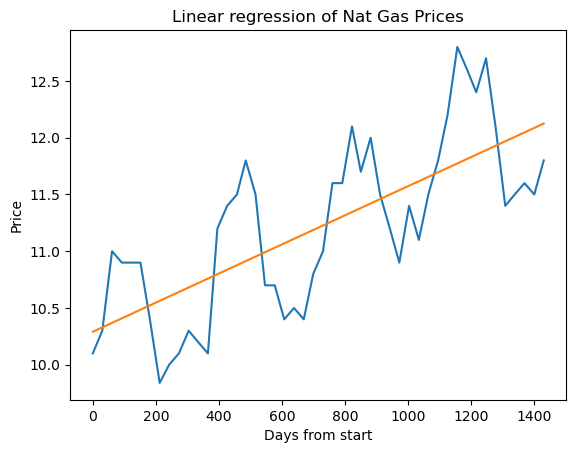

In [58]:
# Try simple linear regression
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar))/ np.sum((x - xbar)**2)
    intercept = ybar - slope*xbar
    return slope, intercept

time = df['Date_ordinal']
slope, intercept = simple_regression(time, prices)


plt.plot(time, prices)
plt.plot(time, slope*time + intercept)
plt.xlabel('Days from start')
plt.ylabel('Price')
plt.title('Linear regression of Nat Gas Prices')

Since it follows a 12 month trend we can y = A sin(kt + z) with frequency = 12
use bilinear regression, with no intercept, to solve for u = Acos(z), w = Asin(z)

Text(0.5, 1.0, 'Smoothed Estimates of Nat Gas Prices')

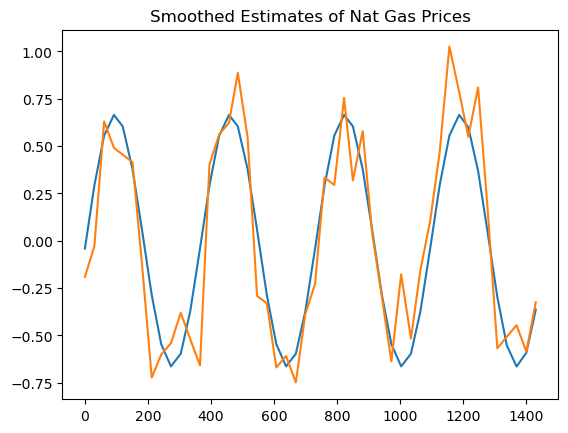

In [39]:
# Try bilear regression
sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))



def bilinear_regression(y,x1,x2):
    slope1 = np.sum(y*x1) / np.sum(x1**2)
    slope2 = np.sum(y*x2) / np.sum(x2**2)
    return slope1, slope2

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

A = np.sqrt(slope1**2 + slope2**2)
z = np.arctan(slope2/slope1)
plt.plot(time, A * np.sin(time * 2 * np.pi / 365 + z))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimates of Nat Gas Prices')




In [52]:
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in df['Date_ordinal'].values:
        # Exact match found in the data
        return df[df['Date_ordinal'] == days]['Prices'].values[0]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return A * np.sin(days * 2 * np.pi / 365 + z) + days * slope + intercept


Text(0.5, 1.0, 'Interpolated Nat Gas Prices')

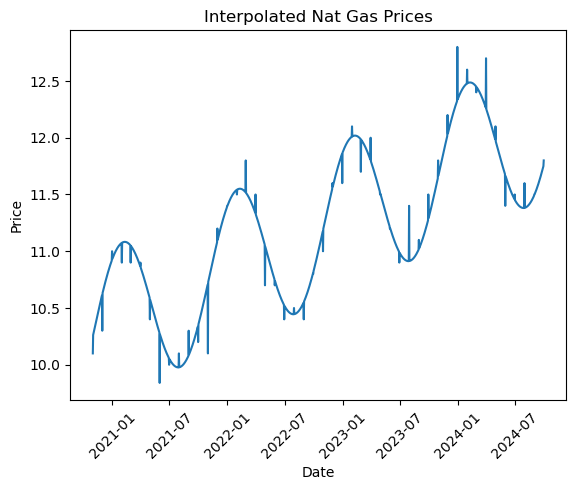

In [57]:
all_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')
plt.plot(all_dates, [interpolate(date) for date in all_dates], label='Smoothed Estimate')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Interpolated Nat Gas Prices')

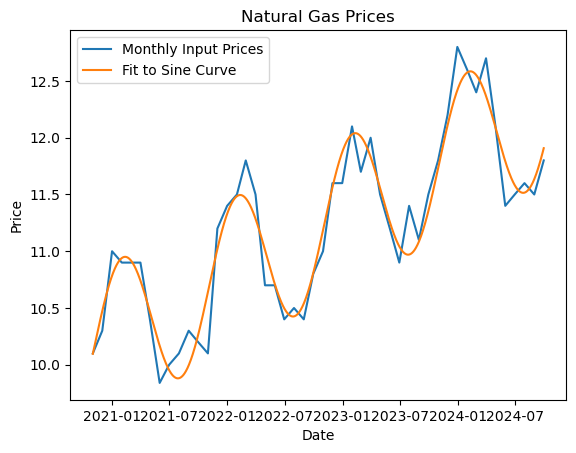

In [61]:
# Fit the monthly input prices to the sine curve
x = np.array(df['Date_ordinal'])
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(df['Dates'].values, y, label='Monthly Input Prices')
plt.plot(all_dates, fit_amplitude * np.sin((all_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (all_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()


# Task 2 
### Commodity Contract Pricing

You need to create a prototype pricing model that can go through further validation and testing before being put into production. Eventually, this model may be the basis for fully automated quoting to clients, but for now, the desk will use it with manual oversight to explore options with the client. 

You should write a function that is able to use the data you created previously to price the contract. The client may want to choose multiple dates to inject and withdraw a set amount of gas, so your approach should generalize the explanation from before. Consider all the cash flows involved in the product.

The input parameters that should be taken into account for pricing are:

Injection dates. 
Withdrawal dates.
The prices at which the commodity can be purchased/sold on those dates.
The rate at which the gas can be injected/withdrawn.
The maximum volume that can be stored.
Storage costs.
Write a function that takes these inputs and gives back the value of the contract. You can assume there is no transport delay and that interest rates are zero. Market holidays, weekends, and bank holidays need not be accounted for. 

In [ ]:
def price_contract(injection_dates, withdrawal_dates, in_prices,out_prices, rate, max_volume, storage_cost):

    total_injected = rate * len(injection_dates)
    total_withdrawn = rate * len(withdrawal_dates)

    if total_injected - total_withdrawn > max_volume:
        return "Total volume exceeds max volume"
 
    injection_costs = sum([rate * gas_price(date) for date in injection_dates])
    withdrawl_revenue = sum([rate*gas_price(date) for date in withdrawal_dates])

    # calculate storage costs
    total_injected = rate * len(injection_dates)
    total_withdrawn = rate * len(withdrawal_dates)
    total_days = (pd.to_datetime(withdrawal_dates).max() - pd.to_datetime(injection_dates).min()).days
    avg_volume = (total_injected - total_withdrawn) / 2
    total_storage_cost = storage_cost * avg_volume * total_days

    return withdrawl_revenue - injection_costs - total_storage_cost





# Task 3
### Credit Risk Analysis

The risk manager has collected data on the loan borrowers. The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

You should produce a function that can take in the properties of a loan and output the expected loss.
You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.

In [64]:
df = pd.read_csv('../Data/Loan_Data.csv')


In [69]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define a function to prepare the data
def prepare_data(df, feature_columns, target_column):
    X = df[feature_columns].copy()
    y = df[target_column]
    return train_test_split(X, y, test_size=0.3, random_state=42)



# Extracting the desired features and target variable
feature_cols = df.columns[1:7].tolist()
X_train, X_test, y_train, y_test = prepare_data(df, feature_cols, 'default')

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)



# Train the model and evaluate
print(f"Accuracy of the Random Forest model: {accuracy:.2f}")


Accuracy of the Random Forest model: 0.99


In [71]:
def get_loan_data(feature_names):
    """Function to get loan data from the user."""
    loan_data = []
    print("Enter the loan data for prediction:")
    for col in feature_names:
        while True:
            try:
                value = float(input(f"Enter value for {col}: "))
                loan_data.append(value)
                break
            except ValueError:
                print(f"Invalid input. Please enter a numeric value for {col}.")
    return loan_data

def calculate_expected_loss(rf_clf, feature_names, loan_data):
    """Function to calculate the expected loss of a loan."""
    if 'loan_amt_outstanding' not in feature_names:
        raise ValueError("Feature 'loan_amt_outstanding' is required in feature_names.")

    # Calculating the Probability of Default
    PD = rf_clf.predict_proba([loan_data])[0][1]

    # Given recovery rate
    recovery_rate = 0.10
    LGD = 1 - recovery_rate

    # Exposure at Default (EAD)
    EAD_index = feature_names.index('loan_amt_outstanding')
    EAD = loan_data[EAD_index]

    # Expected Loss
    EL = PD * LGD * EAD
    return EL

# Main execution
loan_data = get_loan_data(feature_cols)
expected_loss = calculate_expected_loss(rf_clf, feature_cols, loan_data)
print(f"Expected Loss for the loan is: ${expected_loss:.2f}")


Enter the loan data for prediction:
Expected Loss for the loan is: $3323.94


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Task 4
### Bucket FICO Scores

In [76]:
fico_scores = df['fico_score'].values

def get_number_of_buckets(default=5):
    """Get the number of buckets from the user with a default fallback."""
    try:
        return int(input("Please enter the number of buckets you'd like: "))
    except ValueError:
        print("Please enter a valid integer for the number of buckets.")
        return default

def normalize_scores(scores, min_score=300, max_score=850):
    """Normalize the FICO scores."""
    return (scores - min_score) / (max_score - min_score)

def apply_kmeans_clustering(data, n_clusters, scores):
    """Apply K-means clustering and assign ratings."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scores.reshape(-1, 1))
    data['bucket_labels'] = kmeans.labels_

    # Sort cluster centers and assign ratings
    sorted_centers = sorted(enumerate(kmeans.cluster_centers_.flatten()), key=lambda x: x[1], reverse=True)
    ratings = {index: rank/(n_clusters-1) for rank, (index, _) in enumerate(sorted_centers)}
    data['ratings'] = data['bucket_labels'].apply(lambda x: ratings[x])

    return kmeans

def calculate_mse_for_buckets(data, kmeans):
    """Calculate MSE for each bucket."""
    data['normalized_fico'] = normalize_scores(data['fico_score'])
    def calculate_mse(bucket):
        cluster_center = kmeans.cluster_centers_[bucket['bucket_labels'].iloc[0]]
        return np.mean((bucket['normalized_fico'] - cluster_center) ** 2)

    return data.groupby('bucket_labels').apply(calculate_mse)

def print_bucket_info(data):
    """Print information about the buckets."""
    bucket_minima = data.groupby('ratings')['fico_score'].min().values
    print("\nFICO boundaries after optimization:", sorted([300] + list(bucket_minima) + [850]))

    print("\nRatings for each bucket:")
    for rating, boundary in zip(sorted(data['ratings'].unique()), sorted(bucket_minima)):
        print(f"Boundary: {boundary}, Rating: {rating}")


N = get_number_of_buckets()

normalized_scores = normalize_scores(fico_scores)
print("\nFICO score boundaries before optimization:", [300, 850])

data = pd.DataFrame({'fico_score': fico_scores})  # Assuming data is a pandas DataFrame
kmeans = apply_kmeans_clustering(data, N, normalized_scores)

print_bucket_info(data)

mse_values = calculate_mse_for_buckets(data, kmeans)
print("\nMean Squared Error values for each bucket:")
print(mse_values)



FICO score boundaries before optimization: [300, 850]

FICO boundaries after optimization: [300, 408, 525, 570, 605, 638, 669, 703, 745, 850]

Ratings for each bucket:
Boundary: 408, Rating: 0.0
Boundary: 525, Rating: 0.14285714285714285
Boundary: 570, Rating: 0.2857142857142857
Boundary: 605, Rating: 0.42857142857142855
Boundary: 638, Rating: 0.5714285714285714
Boundary: 669, Rating: 0.7142857142857143
Boundary: 703, Rating: 0.8571428571428571
Boundary: 745, Rating: 1.0

Mean Squared Error values for each bucket:
bucket_labels
0    0.000321
1    0.000259
2    0.000446
3    0.000516
4    0.000293
5    0.001437
6    0.000309
7    0.001525
dtype: float64


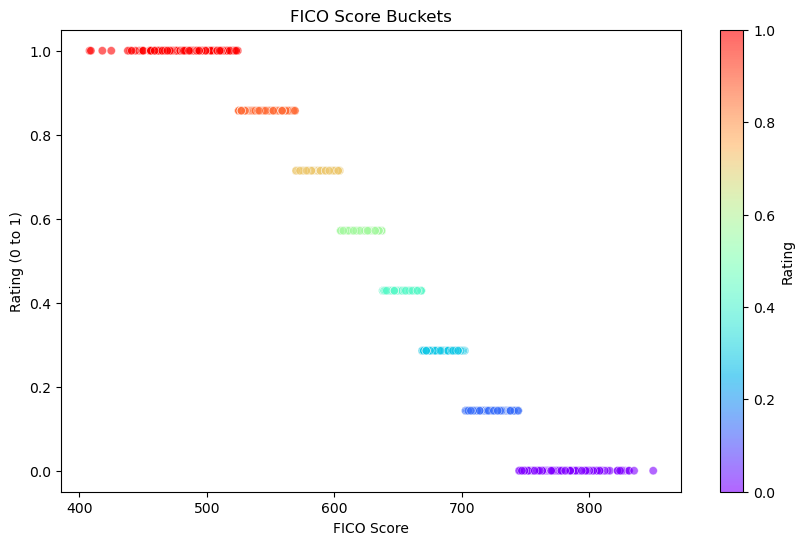

In [77]:
plt.figure(figsize=(10, 6))
plt.scatter(data['fico_score'], data['ratings'], c=data['ratings'], cmap='rainbow', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.xlabel('FICO Score')
plt.ylabel('Rating (0 to 1)')
plt.title('FICO Score Buckets')
plt.colorbar(label='Rating')
plt.show()